#Sumário Executivo

Este estudo avalia o impacto de um desconto de 15% sobre o desempenho de vendas utilizando metodologia Diff-in-Diff para isolar o efeito causal da promoção.

**Principais resultados:**

*Purchases*: aumento médio de +636 unidades por empresa (estatisticamente robusto).

*Pack Views*: crescimento significativo de tráfego, sugerindo maior exposição ao produto.

*Conversion*: aumento observado, porém sem poder estatístico suficiente para conclusões definitivas.

**Poder Estatístico**

O experimento estava adequadamente dimensionado para detectar efeitos em volume (purchases e views), mas subdimensionado para detectar pequenas variações na taxa de conversão.

**Elasticidade e Simulação de 25%**

A elasticidade estimada a partir do desconto de 15% sugere resposta positiva da demanda, especialmente nas faixas intermediárias de preço.

**No cenário hipotético de 25%:**

O desconto exigiria aproximadamente +13% de lift adicional para atingir break-even em relação ao cenário de 15%.

Observa-se elevada taxa de canibalização (~82%), indicando que parte do volume incremental pode refletir antecipação ou redistribuição de demanda.

**Conclusão**\
O desconto de 15% demonstrou impacto incremental robusto em volume.
A extensão para 25% deve ser testada de forma controlada, priorizando segmentos com maior elasticidade-preço e considerando explicitamente os efeitos sobre margem e canibalização.

#0.Contexto do Case

##0.1 Objetivo da análise

Avaliar o impacto causal de um desconto de 15% no desempenho de class packs.

##0.2 Estrutura do Experimento



*  Grupo Teste vs Grupo Controle
*   Período Pré vs Pós
*   Métricas de funil: Views → Purchases → Conversion

#1.Carregamento e entendimento inicial dos dados

##1.1 Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, levene, mannwhitneyu, fisher_exact
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize
from statsmodels.stats.power import NormalIndPower
from scipy.stats import norm
import scipy.stats as stats




##1.2 Carregamento do dataset

In [2]:
df_raw = pd.read_excel("excel_file", sheet_name='Raw Data')

##1.3 Dicionário de dados

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Company ID                  400 non-null    int64 
 1   Period                      400 non-null    object
 2   Test Cohort                 400 non-null    object
 3   Pack Views                  400 non-null    int64 
 4   Purchases                   400 non-null    int64 
 5   Market_Standard_Pack_Price  400 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 18.9+ KB


Dicionário


*Company ID*: Unique ID corresponding to a studio/company\
*Period*: If data corresponds to pre-test or post-test\
*Test Cohort*: Control - no discount; Test - 15% discount\
*Pack Views*: Count of Views to the pack purchase page\
*Purchases*: Count of Purchases made during period\
*Market Standard Pack Price* : Cost of a pack, pre-discount



#2.Checagens de qualidade e integridade do experimento

##2.1 Verificação dos nulos

In [4]:
df_raw.isnull().count()

,0
Company ID,400
Period,400
Test Cohort,400
Pack Views,400
Purchases,400
Market_Standard_Pack_Price,400


Sem valores nulos

##2.2 Verificação de registros duplicados

In [5]:
df_duplicates = df_raw[df_raw.duplicated(keep=False)]

In [6]:
df_duplicates

,Company ID,Period,Test Cohort,Pack Views,Purchases,Market_Standard_Pack_Price


Sem valores duplicados

##2.3 Cada empresa possui observação em Pre e Post?

In [7]:
df_raw.groupby("Company ID")["Period"].nunique().value_counts()

,count
Period,
2,200


Todas as empresas possuem Pre e Post

##2.4 Verificação de vazamento de tratamento

Uma mesma empresa não deve ter mudado de grupo de preço entre o pre e post pois anula a "causalidade"

In [8]:
df_raw.groupby("Company ID")["Test Cohort"].nunique().value_counts()

,count
Test Cohort,
1,199
2,1


In [9]:
df_raw.groupby("Company ID")["Test Cohort"].nunique().sort_values(ascending=False).head()

,Test Cohort
Company ID,
101,2
1,1
3,1
2,1
5,1


##2.5 Exclusão de observações inválidas

A empresa company id 101 não será considerada na análise.

In [10]:
INVALID_COMPANY_IDS = [101]

In [11]:
df_clean = df_raw[~df_raw["Company ID"].isin(INVALID_COMPANY_IDS)].copy()

1 empresa precisou ser excluída da análise

##2.6 Preço do pack é fixo por empresa?

In [12]:
df_clean.groupby("Company ID")["Market_Standard_Pack_Price"].nunique().value_counts()

,count
Market_Standard_Pack_Price,
1,199


Os preços por empresa não mudaram

##2.7 Sanity check do funil (Views ≥ Purchases)

In [13]:
(df_clean["Pack Views"] > df_clean["Purchases"]).mean()

np.float64(1.0)

A quantidade de views foi maior do que a quantidade de purchases

In [14]:
df_clean = df_clean.rename(columns={
    "Company ID": "company_id",
    "Period": "period",
    "Test Cohort": "test_cohort",
    "Pack Views": "pack_views",
    "Purchases": "purchases",
    "Market_Standard_Pack_Price": "market_standard_pack_price"
})

df_clean["period"] = df_clean["period"].str.lower()
df_clean["test_cohort"] = df_clean["test_cohort"].str.lower()



#3.Construção de métricas derivadas

##3.1 Criação da taxa de conversão

In [15]:
df_clean["conversion"] = df_clean["purchases"] / df_clean["pack_views"]


#4.Análise exploratória (EDA)

In [16]:
FUNNEL_METRICS = ["pack_views", "purchases", "conversion"]


##4.2 Estatísticas por período e faixa de preço

In [17]:
tbl_eda_by_period_price_cohort = (
    df_clean
        .groupby(["period", "market_standard_pack_price", "test_cohort"])[FUNNEL_METRICS]
        .mean()
)

tbl_eda_by_period_price_cohort


pack_views   purchases  \
period market_standard_pack_price test_cohort                            
post   10                         control      1019.083333  456.083333   
                                  test         1312.500000  496.600000   
       15                         control      3741.483871  635.129032   
                                  test         5524.410256  882.794872   
       20                         control      6450.892857  481.785714   
                                  test         8059.818182  641.090909   
       25                         control      6326.379310  137.931034   
                                  test         7758.392857  247.071429   
pre    10                         control      1045.083333  483.666667   
                                  test         1151.100000  409.900000   
       15                         control      3672.741935  634.516129   
                                  test         4897.205128  736.000000   
       20                         control      6252.107143  484.714286   
                                  test         7088.136364  525.909091   
       25                         control      6275.724138  135.034483   
                                  test         6892.785714  195.928571   

                                               conversion  
period market_standard_pack_price test_cohort              
post   10                         control        0.463443  
                                  test           0.363376  
       15                         control        0.195796  
                                  test           0.178785  
       20                         control        0.076372  
                                  test           0.080780  
       25                         control        0.021790  
                                  test           0.032102  
pre    10                         control        0.468597  
                                  test           0.339384  
       15                         control        0.203272  
                                  test           0.168548  
       20                         control        0.076470  
                                  test           0.074813  
       25                         control        0.021306  
                                  test           0.028577

**Pack Views** - A campanha aumentou significativamente o número de visualizações de pacotes, indicando maior exposição e interesse inicial.

**Purchases** - Observou-se aumento robusto no volume de compras, com efeito estatisticamente significativo, sugerindo impacto incremental positivo do desconto

**Conversão** - A taxa de conversão apresentou variação modesta e estatisticamente inconclusiva. Embora o volume tenha crescido, o experimento não possuía poder estatístico suficiente para detectar pequenas mudanças na conversão.

O descolamento entre aumento de visualizações e variação limitada na conversão sugere que parte do efeito ocorreu via ampliação de tráfego, e não necessariamente via maior eficiência do funil.

##4.3 Distribuição das empresas por faixa de preço

<Axes: title={'center': 'Distribuição de preços dos packs'}, xlabel='Preço do pack', ylabel='% de empresas'>

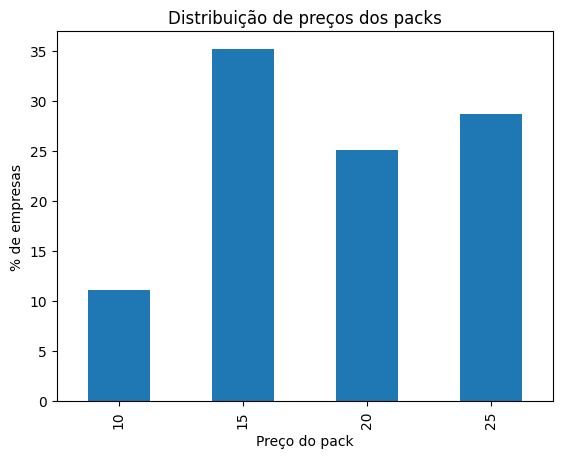

In [18]:
tbl_price_distribution = (
    df_clean["market_standard_pack_price"]
    .value_counts(normalize=True)
    .sort_index()
    * 100
)

tbl_price_distribution.rename_axis("Preço do pack").plot(kind="bar", ylabel="% de empresas",
                                              title="Distribuição de preços dos packs")



A quantidade de empresas por pack de preço é bem diferente,

##4.5 Comparação da distribuição de preços entre Test e Control

In [19]:
tbl_price_distribution_by_cohort = (
    df_clean.groupby("test_cohort")["market_standard_pack_price"]
    .value_counts(normalize=True)
    .sort_index()
    * 100
)

tbl_price_distribution_by_cohort

test_cohort  market_standard_pack_price
control      10                            12.000000
             15                            31.000000
             20                            28.000000
             25                            29.000000
test         10                            10.101010
             15                            39.393939
             20                            22.222222
             25                            28.282828
Name: proportion, dtype: float64

##4.6 Médias agregadas por período e grupo (visão inicial)

In [20]:
tbl_mean_by_period_cohort = df_clean.groupby(
    ["period", "test_cohort"]
)[FUNNEL_METRICS].mean()

tbl_mean_by_period_cohort

pack_views   purchases  conversion
period test_cohort                                     
post   control      4923.050000  426.520000    0.144013
       test         6294.222222  610.272727    0.134166
pre    control      4834.510000  429.620000    0.146836
       test         5570.090909  503.626263    0.125386

##4.7 Médias agregadas por período e grupo (visão inicial)

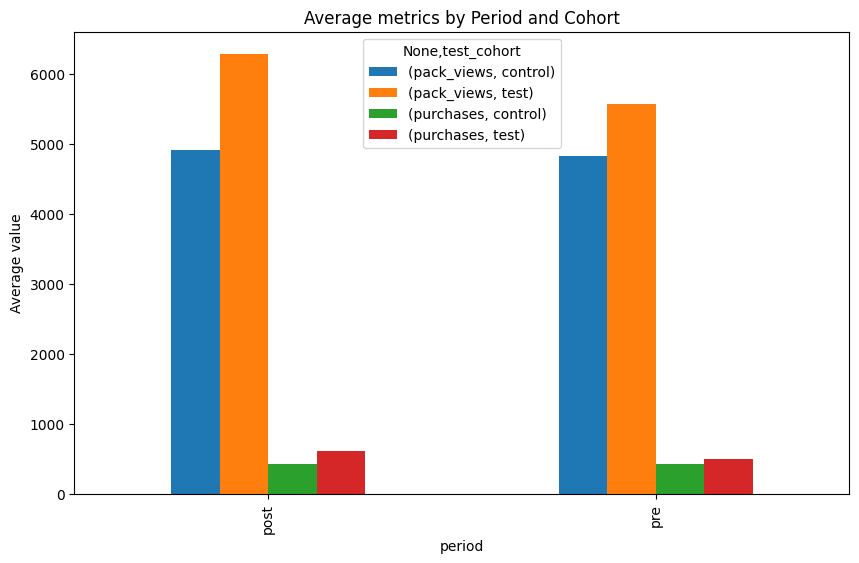

In [21]:
tbl_mean_by_period_cohort.unstack("test_cohort")[["pack_views","purchases"]].plot(kind="bar", figsize=(10,6))
plt.title("Average metrics by Period and Cohort")
plt.ylabel("Average value")
plt.show()


Objetivo do pré-teste: verificar se Controle e Teste eram comparáveis antes da intervenção (desconto).

#5.Validação de comparabilidade no pré-período (Baseline)

Objetivo: verificar se Teste e Controle eram comparáveis antes do desconto.

##5.1 Baseline agregado — Pack Views

###5.1.1 Seleção dos dados

In [22]:
s_views_pre_control = df_clean[
    (df_clean["test_cohort"] == "control") &
    (df_clean["period"] == "pre")
]["pack_views"]

s_views_pre_test = df_clean[
    (df_clean["test_cohort"] == "test") &
    (df_clean["period"] == "pre")
]["pack_views"]


###5.1.2 Teste de homogeneidade de variância (Levene)

In [23]:
levene_stat,levene_pvalue = levene(s_views_pre_test , s_views_pre_control)

print(f"Levene test (variances): statistic = {levene_stat:.4f}, p-value = {levene_pvalue:.4f}")

Levene test (variances): statistic = 4.6042, p-value = 0.0331


###5.1.3 Teste de diferença de médias| t-test

In [24]:
equal_var = levene_pvalue >= 0.05

t_stat, p_val = ttest_ind(s_views_pre_test,  s_views_pre_control, equal_var=equal_var)

print(f"t-test (means): statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

t-test (means): statistic = 1.8816, p-value = 0.0614


##5.2 Baseline agregado — Purchases

###5.2.1 Seleção dos dados

In [25]:
s_purchases_pre_control= df_clean[
    (df_clean["test_cohort"] == "control") &
    (df_clean["period"] == "pre")
]["purchases"]

s_purchases_pre_test= df_clean[
    (df_clean["test_cohort"] == "test") &
    (df_clean["period"] == "pre")
]["purchases"]



###5.2.2 Teste de homogeneidade de variância | Levene

In [26]:
levene_stat,levene_pvalue= levene(s_purchases_pre_test,s_purchases_pre_control)

print(f"Levene test (variances): statistic = {levene_stat:.4f}, p-value = {levene_pvalue:.4f}")


Levene test (variances): statistic = 0.1400, p-value = 0.7087


###5.2.3 Teste de diferença de médias| t-test

In [27]:
equal_var =levene_pvalue >= 0.05

t_stat, p_val = ttest_ind(s_purchases_pre_test, s_purchases_pre_control, equal_var=equal_var)

print(f"t-test (means): statistic = {t_stat:.4f}, p-value = {p_val:.4f}")


t-test (means): statistic = 1.7474, p-value = 0.0821


##5.3 Baseline agregado — Conversion

##5.3.1 Seleção dos dados

In [28]:
s_conversion_pre_control= df_clean[
    (df_clean["test_cohort"] == "control") &
    (df_clean["period"] == "pre")
]

s_conversion_pre_test = df_clean[
    (df_clean["test_cohort"] == "test") &
    (df_clean["period"] == "pre")
]


##5.3.2 Teste de proporções | Z Test

In [29]:
success_test = s_purchases_pre_test.sum()
n_test = s_views_pre_test.sum()

success_control = s_purchases_pre_control.sum()
n_control = s_views_pre_control.sum()

stat, p_val = proportions_ztest(
    [success_test, success_control],
    [n_test, n_control]
)

print(f"Z-test (proportions): statistic = {stat:.4f}, p-value = {p_val:.4f}")



Z-test (proportions): statistic = 2.7548, p-value = 0.0059


#6.Baseline por faixa de preço

Verificar se a comparabilidade se mantém dentro de cada segmento.

In [30]:

df_pre_period =df_clean[df_clean["period"] == "pre"]

tbl_company_count_by_price_cohort = (
    df_pre_period.groupby(["market_standard_pack_price", "test_cohort"])["company_id"]
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
)

tbl_company_count_by_price_cohort.columns.name = None

print(tbl_company_count_by_price_cohort)


   market_standard_pack_price  control  test
0                          10       12    10
1                          15       31    39
2                          20       28    22
3                          25       29    28


*Resultado geral (todos os preços juntos):*

*  Pack Views: não houve diferença significativa (Welch’s t-test, p = 0.0614).
*  Purchases: sem diferença significativa (t-test padrão, p = 0.2385
*  Conversão:  houve diferença significativa (Z-test de proporções, p = 0.0059).

*Conclusão:*\
Os grupos eram comparáveis em volume (views e purchases), mas apresentavam diferença estatística em conversão agregada


#7.Evolução temporal (Pre vs Post)

##7.1 Evolução agregada das métricas

In [31]:
tbl_mean_by_period_cohort = (
    df_clean
        .groupby(["test_cohort", "period"])[FUNNEL_METRICS]
        .mean()
)

tbl_evolution_wide = tbl_mean_by_period_cohort.unstack("period")

tbl_evolution_wide[("purchases", "delta")] = (
    tbl_evolution_wide[("purchases", "post")] -
    tbl_evolution_wide[("purchases", "pre")]
)

tbl_evolution_wide[("pack_views", "delta")] = (
    tbl_evolution_wide[("pack_views", "post")] -
    tbl_evolution_wide[("pack_views", "pre")]
)

tbl_evolution_wide[("conversion", "delta")] = (
    tbl_evolution_wide[("conversion", "post")] -
    tbl_evolution_wide[("conversion", "pre")]
)

did_purchases = (
    tbl_evolution_wide.loc["test", ("purchases", "delta")] -
    tbl_evolution_wide.loc["control", ("purchases", "delta")]
)
tbl_evolution_wide.loc["diff_in_diff", ("purchases", "delta")] = did_purchases

did_pack_views = (
    tbl_evolution_wide.loc["test", ("pack_views", "delta")] -
    tbl_evolution_wide.loc["control", ("pack_views", "delta")]
)
tbl_evolution_wide.loc["diff_in_diff", ("pack_views", "delta")] = did_pack_views

did_conversion = (
    tbl_evolution_wide.loc["test", ("conversion", "delta")] -
    tbl_evolution_wide.loc["control", ("conversion", "delta")]
)
tbl_evolution_wide.loc["diff_in_diff", ("conversion", "delta")] = did_conversion
ordered_columns = [
    ("purchases", "pre"), ("purchases", "post"), ("purchases", "delta"),
    ("pack_views", "pre"), ("pack_views", "post"), ("pack_views", "delta"),
    ("conversion", "pre"), ("conversion", "post"), ("conversion", "delta"),
]

tbl_evolution_final = tbl_evolution_wide[ordered_columns]
display(
    tbl_evolution_final
        .sort_index()
        .style
        .format("{:.4f}", na_rep="-")
)

##7.1 Evolução agregada das métricas por faixa de preço

In [32]:
tbl_mean_by_price_period_cohort = (
    df_clean
        .groupby(["market_standard_pack_price", "period", "test_cohort"])[FUNNEL_METRICS]
        .mean()
)
tbl_price_evolution_wide = tbl_mean_by_price_period_cohort.unstack("period")

tbl_price_evolution_wide[("purchases", "delta")] = (
    tbl_price_evolution_wide[("purchases", "post")] -
    tbl_price_evolution_wide[("purchases", "pre")]
)

tbl_price_evolution_wide[("pack_views", "delta")] = (
    tbl_price_evolution_wide[("pack_views", "post")] -
    tbl_price_evolution_wide[("pack_views", "pre")]
)

tbl_price_evolution_wide[("conversion", "delta")] = (
    tbl_price_evolution_wide[("conversion", "post")] -
    tbl_price_evolution_wide[("conversion", "pre")]
)

tbl_test_delta = tbl_price_evolution_wide.xs("test", level="test_cohort")
tbl_control_delta = tbl_price_evolution_wide.xs("control", level="test_cohort")

tbl_did_price = (
    tbl_test_delta[
        [("purchases","delta"),
         ("pack_views","delta"),
         ("conversion","delta")]
    ]
    -
    tbl_control_delta[
        [("purchases","delta"),
         ("pack_views","delta"),
         ("conversion","delta")]
    ]
)
tbl_did_price["test_cohort"] = "diff_in_diff"
tbl_did_price = tbl_did_price.set_index("test_cohort", append=True)

tbl_price_evolution_final = (
    pd.concat([tbl_price_evolution_wide, tbl_did_price])
        .sort_index()
)
ordered_columns = [
    ("purchases", "pre"), ("purchases", "post"), ("purchases", "delta"),
    ("pack_views", "pre"), ("pack_views", "post"), ("pack_views", "delta"),
    ("conversion", "pre"), ("conversion", "post"), ("conversion", "delta"),
]

tbl_price_evolution_final = tbl_price_evolution_final[ordered_columns]

display(
    tbl_price_evolution_final
        .style
        .format("{:.4f}", na_rep="-")
)

#8.Estimativa do efeito causal — Diff-in-Diff (por médias)

##8.1.Pack Views

###8.1.1 Tabela 2×2

In [33]:
tbl_pack_views = (
    df_clean
        .groupby(["test_cohort", "period"])["pack_views"]
        .mean()
        .unstack("period")
)

###8.1.2 Cálculo do Diff-in-Diff

In [34]:
tbl_pack_views["delta"] = (
    tbl_pack_views["post"] -
    tbl_pack_views["pre"]
)
did_pack_views = (
    tbl_pack_views.loc["test", "delta"] -
    tbl_pack_views.loc["control", "delta"]
)

tbl_pack_views.loc["diff_in_diff", "delta"] = did_pack_views

tbl_pack_views


period,post,pre,delta
test_cohort,,,
control,4923.050000,4834.510000,88.540000
test,6294.222222,5570.090909,724.131313
diff_in_diff,NaN,NaN,635.591313


##8.2.Purchases

###8.2.1 Tabela 2×2

In [35]:
tbl_purchases = (
    df_clean
        .groupby(["test_cohort", "period"])["purchases"]
        .mean()
        .unstack("period")
)
tbl_purchases["delta"] = (
    tbl_purchases["post"] -
    tbl_purchases["pre"]
)

###8.2.2 Cálculo do Diff-in-Diff

In [36]:
did_purchases = (
    tbl_purchases.loc["test", "delta"] -
    tbl_purchases.loc["control", "delta"]
)

tbl_purchases.loc["diff_in_diff", "delta"] = did_purchases

tbl_purchases

period,post,pre,delta
test_cohort,,,
control,426.520000,429.620000,-3.100000
test,610.272727,503.626263,106.646465
diff_in_diff,NaN,NaN,109.746465


##8.3.Conversion

###8.3.1 Tabela 2×2

In [37]:
tbl_conversion = (
    df_clean
        .groupby(["test_cohort", "period"])["conversion"]
        .mean()
        .unstack("period")
)
tbl_conversion["delta"] = (
    tbl_conversion["post"] -
    tbl_conversion["pre"]
)



###8.3.2 Cálculo do Diff-in-Diff

In [38]:
did_conversion = (
    tbl_conversion.loc["test", "delta"] -
    tbl_conversion.loc["control", "delta"]
)

tbl_conversion.loc["diff_in_diff", "delta"] = did_conversion

tbl_conversion



period,post,pre,delta
test_cohort,,,
control,0.144013,0.146836,-0.002823
test,0.134166,0.125386,0.008779
diff_in_diff,NaN,NaN,0.011602


#9.Resultados principais do Diff-in-Diff

##9.1 Tabela resumo dos efeitos

In [39]:
tbl_did_summary = pd.Series(
    {
        "pack_views": did_pack_views,
        "purchases": did_purchases,
        "conversion": did_conversion,
    },
    name="diff_in_diff"
).to_frame()

tbl_did_summary.round(4)

,diff_in_diff
pack_views,635.5913
purchases,109.7465
conversion,0.0116


#10.Análise de Poder

Objetivo - Avaliar se o experimento tinha poder estatístico suficiente para detectar um aumento mínimo relevante na taxa de conversão.\
Em geral, considera-se adequado poder ≥ 80%.

In [40]:
ALPHA = 0.05
TARGET_POWER = 0.80
z_alpha = norm.ppf(1 - ALPHA/2)
z_beta = norm.ppf(TARGET_POWER)

##10.1 Conversão

In [41]:

df_panel_conversion = (
    df_clean
        .pivot_table(
            index=["company_id", "test_cohort"],
            columns="period",
            values=["purchases", "pack_views"],
            aggfunc="sum"
        )
        .reset_index()
)
df_panel_conversion["conv_pre"] = (
    df_panel_conversion[("purchases", "pre")] /
    df_panel_conversion[("pack_views", "pre")]
)

df_panel_conversion["conv_post"] = (
    df_panel_conversion[("purchases", "post")] /
    df_panel_conversion[("pack_views", "post")]
)

df_panel_conversion["delta"] = (
    df_panel_conversion["conv_post"] -
    df_panel_conversion["conv_pre"]
)

s_delta_conversion_test = (
    df_panel_conversion[df_panel_conversion["test_cohort"]=="test"]["delta"]
)

s_delta_conversion_control = (
    df_panel_conversion[df_panel_conversion["test_cohort"]=="control"]["delta"]
)

n_test = len(s_delta_conversion_test)
n_control = len(s_delta_conversion_control)

effect_conversion = (
    s_delta_conversion_test.mean() -
    s_delta_conversion_control.mean()
)

p_pool = df_panel_conversion["conv_pre"].mean()

In [42]:
se_conversion = np.sqrt(
    p_pool*(1-p_pool)/n_test +
    p_pool*(1-p_pool)/n_control
)

ci_low_conversion = effect_conversion - z_alpha * se_conversion
ci_high_conversion = effect_conversion + z_alpha * se_conversion

z_effect_conversion = effect_conversion / se_conversion

power_conversion = 1 - norm.cdf(z_alpha - z_effect_conversion)

mde_conversion = (z_alpha + z_beta) * se_conversion


In [43]:
print(f"Efeito: {effect_conversion:.4f}")
print(f"IC95%: [{ci_low_conversion:.4f}, {ci_high_conversion:.4f}]")
print(f"Power: {power_conversion:.3f}")
print(f"MDE: {mde_conversion:.4f}")


Efeito: 0.0116
IC95%: [-0.0837, 0.1069]
Power: 0.043
MDE: 0.1362


##10.2 Purchases

In [44]:

df_panel_purchases = (
    df_clean
        .pivot_table(
            index=["company_id", "test_cohort"],
            columns="period",
            values="purchases",
            aggfunc="sum"
        )
        .reset_index()
)

df_panel_purchases = df_panel_purchases.dropna(subset=["pre", "post"]).copy()

df_panel_purchases["delta"] = (
    df_panel_purchases["post"] -
    df_panel_purchases["pre"]
)

s_delta_purchases_test = (
    df_panel_purchases[df_panel_purchases["test_cohort"]=="test"]["delta"]
)

s_delta_purchases_control = (
    df_panel_purchases[df_panel_purchases["test_cohort"]=="control"]["delta"]
)

n_test = len(s_delta_purchases_test)
n_control = len(s_delta_purchases_control)

effect_purchases = (
    s_delta_purchases_test.mean() -
    s_delta_purchases_control.mean()
)


In [45]:
se_purchases = np.sqrt(
    s_delta_purchases_test.var(ddof=1)/n_test +
    s_delta_purchases_control.var(ddof=1)/n_control
)

ci_low_purchases = effect_purchases - z_alpha * se_purchases
ci_high_purchases = effect_purchases + z_alpha * se_purchases

std_pooled = np.sqrt(
    ((n_test-1)*s_delta_purchases_test.var(ddof=1) +
     (n_control-1)*s_delta_purchases_control.var(ddof=1)) /
    (n_test + n_control - 2)
)

d = effect_purchases / std_pooled

delta_nc = d * np.sqrt((n_test*n_control)/(n_test+n_control))

power_purchases = 1 - norm.cdf(z_alpha - delta_nc)

denominator = np.sqrt((n_test*n_control)/(n_test+n_control))

d_mde = (z_alpha + z_beta) / denominator

mde_purchases = d_mde * std_pooled

In [46]:

print(f"Efeito: {effect_purchases:.2f}")
print(f"IC95%: [{ci_low_purchases:.2f}, {ci_high_purchases:.2f}]")
print(f"Power: {power_purchases:.3f}")
print(f"MDE: {mde_purchases:.2f}")


Efeito: 109.75
IC95%: [89.70, 129.80]
Power: 1.000
MDE: 28.62


##10.3 Click Views

In [47]:
df_panel_views = (
    df_clean
        .pivot_table(
            index=["company_id", "test_cohort"],
            columns="period",
            values="pack_views",
            aggfunc="sum"
        )
        .reset_index()
)

df_panel_views = df_panel_views.dropna(subset=["pre", "post"]).copy()

df_panel_views["delta"] = (
    df_panel_views["post"] -
    df_panel_views["pre"]
)

s_delta_views_test = (
    df_panel_views[df_panel_views["test_cohort"]=="test"]["delta"]
)

s_delta_views_control = (
    df_panel_views[df_panel_views["test_cohort"]=="control"]["delta"]
)

n_test = len(s_delta_views_test)
n_control = len(s_delta_views_control)

effect_views = (
    s_delta_views_test.mean() -
    s_delta_views_control.mean()
)


In [48]:
se_views = np.sqrt(
    s_delta_views_test.var(ddof=1)/n_test +
    s_delta_views_control.var(ddof=1)/n_control
)

ci_low_views = effect_views - z_alpha * se_views
ci_high_views = effect_views + z_alpha * se_views

std_pooled = np.sqrt(
    ((n_test-1)*s_delta_views_test.var(ddof=1) +
     (n_control-1)*s_delta_views_control.var(ddof=1)) /
    (n_test + n_control - 2)
)

d = effect_views / std_pooled

delta_nc = d * np.sqrt((n_test*n_control)/(n_test+n_control))

power_views = 1 - norm.cdf(z_alpha - delta_nc)

denominator = np.sqrt((n_test*n_control)/(n_test+n_control))

d_mde = (z_alpha + z_beta) / denominator

mde_views = d_mde * std_pooled

In [49]:
print(f"Efeito: {effect_views:.2f}")
print(f"IC95%: [{ci_low_views:.2f}, {ci_high_views:.2f}]")
print(f"Power: {power_views :.3f}")
print(f"MDE: {mde_views:.2f}")


Efeito: 635.59
IC95%: [480.52, 790.66]
Power: 1.000
MDE: 222.09


###Conclusão do Poder estatistico

1.O experimento foi estatisticamente robusto para métricas de volume (Views e Purchases).

2.O experimento estava subdimensionado para detectar mudanças pequenas em taxa

3.Portanto, a evidência é forte para impacto em volume, mas inconclusiva para eficiência do funil.

#11.Cenário hipotético: desconto de 25%

In [50]:
DISCOUNT_TEST = 0.15
DISCOUNT_SCENARIO = 0.25

In [51]:
tbl_baseline_pre_purchases_by_price = (
    df_clean[
        (df_clean["test_cohort"] == "test") &
        (df_clean["period"] == "pre")
    ]
    .groupby("market_standard_pack_price")["purchases"]
    .mean()
)


In [52]:
tbl_mean_by_price = (
    df_clean
        .groupby(["market_standard_pack_price", "test_cohort", "period"])["purchases"]
        .mean()
        .unstack("period")
)

tbl_mean_by_price["delta"] = (
    tbl_mean_by_price["post"] -
    tbl_mean_by_price["pre"]
)

tbl_test_delta = tbl_mean_by_price.xs("test", level="test_cohort")
tbl_control_delta = tbl_mean_by_price.xs("control", level="test_cohort")

tbl_did_by_price = (
    tbl_test_delta["delta"] -
    tbl_control_delta["delta"]
)


##11.1 Analise de elasticidade

Assumimos elasticidade constante localmente. Essa hipótese pode falhar para descontos mais agressivos.

In [53]:
DISCOUNT_TEST = 0.15

tbl_elasticity_by_price = pd.DataFrame({
    "baseline_pre": tbl_baseline_pre_purchases_by_price,
    "did_effect_15": tbl_did_by_price
})

tbl_elasticity_by_price["pct_delta_q_15"] = (
    tbl_elasticity_by_price["did_effect_15"] /
    tbl_elasticity_by_price["baseline_pre"]
)

tbl_elasticity_by_price["elasticity"] = (
    tbl_elasticity_by_price["pct_delta_q_15"] /
    (-DISCOUNT_TEST)
)

tbl_elasticity_by_price.round(3)


,baseline_pre,did_effect_15,pct_delta_q_15,elasticity
market_standard_pack_price,,,,
10,409.900,114.283,0.279,-1.859
15,736.000,146.182,0.199,-1.324
20,525.909,118.110,0.225,-1.497
25,195.929,48.246,0.246,-1.642


In [54]:
tbl_elasticity_by_price["pct_delta_q_25_constant"] = (
    tbl_elasticity_by_price["elasticity"] *
    (-DISCOUNT_SCENARIO)
)

tbl_elasticity_by_price["delta_q_25_constant"] = (
    tbl_elasticity_by_price["pct_delta_q_25_constant"] *
    tbl_elasticity_by_price["baseline_pre"]
)

In [55]:
tbl_elasticity_by_price["elasticity_reduced"] = (
    tbl_elasticity_by_price["elasticity"] * 0.8
)

tbl_elasticity_by_price["pct_delta_q_25_reduced"] = (
    tbl_elasticity_by_price["elasticity_reduced"] *
    (-DISCOUNT_SCENARIO)
)

tbl_elasticity_by_price["delta_q_25_reduced"] = (
    tbl_elasticity_by_price["pct_delta_q_25_reduced"] *
    tbl_elasticity_by_price["baseline_pre"]
)


In [56]:
tbl_elasticity_by_price["price"] = (
    tbl_elasticity_by_price.index
)

tbl_elasticity_by_price["unit_revenue_25"] = (
    tbl_elasticity_by_price["price"] *
    (1 - DISCOUNT_SCENARIO)
)

tbl_elasticity_by_price["gmv_25_constant"] = (
    tbl_elasticity_by_price["delta_q_25_constant"] *
    tbl_elasticity_by_price["unit_revenue_25"]
)

tbl_elasticity_by_price["gmv_25_reduced"] = (
    tbl_elasticity_by_price["delta_q_25_reduced"] *
    tbl_elasticity_by_price["unit_revenue_25"]
)

tbl_elasticity_by_price.round(2)


,baseline_pre,did_effect_15,pct_delta_q_15,elasticity,pct_delta_q_25_constant,delta_q_25_constant,elasticity_reduced,pct_delta_q_25_reduced,delta_q_25_reduced,price,unit_revenue_25,gmv_25_constant,gmv_25_reduced
market_standard_pack_price,,,,,,,,,,,,,
10,409.90,114.28,0.28,-1.86,0.46,190.47,-1.49,0.37,152.38,10,7.50,1428.54,1142.83
15,736.00,146.18,0.20,-1.32,0.33,243.64,-1.06,0.26,194.91,15,11.25,2740.91,2192.73
20,525.91,118.11,0.22,-1.50,0.37,196.85,-1.20,0.30,157.48,20,15.00,2952.76,2362.21
25,195.93,48.25,0.25,-1.64,0.41,80.41,-1.31,0.33,64.33,25,18.75,1507.70,1206.16


Assumimos que a elasticidade observada com 15% pode ser usada como referência para 25%.
Sob essa hipótese, o desconto de 25% pode gerar maior receita.
Porém, se a resposta da demanda diminuir, o ganho esperado cai de forma relevante.
O efeito varia por faixa de preço, com maior potencial nas faixas intermediárias.

##11.2 Análise de break-even agregado

In [57]:
unit_revenue_15 = 1 - DISCOUNT_TEST
unit_revenue_25 = 1 - DISCOUNT_SCENARIO

break_even_multiplier = unit_revenue_15 / unit_revenue_25

print(f"Break-even multiplier: {break_even_multiplier:.3f}")
print(
    f"25% discount needs {((break_even_multiplier - 1)*100):.1f}% "
    f"more lift than 15% to break even."
)



Break-even multiplier: 1.133
25% discount needs 13.3% more lift than 15% to break even.


###Conclusão Análise de break-even

Para que o desconto de 25% seja melhor que o de 15%, o aumento nas vendas precisa ser pelo menos 13% maior.
Isso ocorre porque cada venda com 25% gera menos receita por unidade.

##11.3Estimativa de Canibalização

In [58]:
post_test_mean = (
    df_clean[
        (df_clean["test_cohort"] == "test") &
        (df_clean["period"] == "post")
    ]["purchases"]
    .mean()
)

estimated_cannibalization_rate = (
    1 - (did_purchases / post_test_mean)
)

print(
    f"Estimated cannibalization rate: "
    f"{estimated_cannibalization_rate:.2%}"
)


Estimated cannibalization rate: 82.02%


Apenas 18% do volume foi realmente incremental.
A maior parte das vendas provavelmente aconteceria mesmo sem o desconto.
Aumentar para 25% pode ampliar o subsídio sem garantir crescimento proporcional.

##Conclusão e Recomendação

O desconto de 25% pode gerar maior receita se o aumento nas vendas for pelo menos 13% maior do que o observado com 15%.

A projeção por faixa de preço mostra potencial ganho caso a demanda continue respondendo da mesma forma. No entanto, se a resposta diminuir, o retorno esperado cai de forma relevante.

Além disso, apenas 18% do volume observado com 15% foi realmente incremental. Isso indica que a maior parte das vendas já ocorreria sem desconto.

Portanto, recomenda-se testar 25% de forma segmentada antes de considerar uma implementação ampla.